In [1]:
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import numpy_groupies as npg
import pandas as pd
import scipy.stats as stats
import scipy.special as ss
import sortedcontainers as sc
import os
import tqdm
import pickle

In [2]:
from statsmodels.discrete.discrete_model import NegativeBinomial as statsNB

In [3]:
os.environ["CAPY_REF_FA"] = "/home/opriebe/data/ref/hg19/Homo_sapiens_assembly19.fasta"
import hapaseg.coverage_MCMC as mcmc_cov
import hapaseg.NB_coverage_MCMC as nb_cov
from capy import mut, seq

Cannot find path to gnomAD index; gnomAD functionality disabled.


In [4]:
import hapaseg.coverage_DP as dp_cov
import hapaseg.a_cov_DP as dp_a_cov

In [5]:
colors = mpl.cm.get_cmap("tab20").colors

In [245]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 30

### Load coverage

In [6]:
Cov = pd.read_csv("exome/6_C1D1_META.cov", sep = "\t", names = ["chr", "start", "end", "covcorr", "covraw"], low_memory=False)
Cov["chr"] = mut.convert_chr(Cov["chr"])
Cov = Cov.loc[Cov["chr"] != 0]
Cov["start_g"] = seq.chrpos2gpos(Cov["chr"], Cov["start"])
Cov["end_g"] = seq.chrpos2gpos(Cov["chr"], Cov["end"])

### Load covariates

In [7]:
Cov["C_len"] = Cov["end"] - Cov["start"] + 1

# load repl timing
F = pd.read_pickle("covars/GSE137764_H1.hg19_liftover.pickle")

# map targets to RT intervals
tidx = mut.map_mutations_to_targets(Cov.rename(columns = { "start" : "pos" }), F, inplace = False)
Cov.loc[tidx.index, "C_RT"] = F.iloc[tidx, 3:].mean(1).values

# z-transform
Cov["C_RT_z"] = (lambda x : (x - np.nanmean(x))/np.nanstd(x))(np.log(Cov["C_RT"] + 1e-20))

#load GC content
B = pd.read_pickle("covars/GC.pickle")
Cov = Cov.merge(B.rename(columns = { "gc" : "C_GC" }), left_on = ["chr", "start", "end"], right_on = ["chr", "start", "end"], how = "left")
Cov["C_GC_z"] = (lambda x : (x - np.nanmean(x))/np.nanstd(x))(np.log(Cov["C_GC"] + 1e-20))

In [8]:
clust = np.load("exome/6_C1D1_META.DP_clusts.auto_ref_correct.overdispersion92.no_phase_correct.npz")

#### Load chromosome boundary coordinates

In [9]:
allelic_segs = pd.read_pickle("exome/6_C1D1_META.allelic_segs.auto_ref_correct.overdispersion92.no_phase_correct.pickle")
chrbdy = allelic_segs.dropna().loc[:, ["start", "end"]]
chr_ends = chrbdy.loc[chrbdy["start"] != 0, "end"].cumsum()

In [10]:
clust["snps_to_clusters"].shape

(500, 11768)

In [11]:
SNPs = pd.read_pickle("exome/6_C1D1_META.SNPs.pickle")
SNPs["chr"], SNPs["pos"] = seq.gpos2chrpos(SNPs["gpos"])

SNPs["tidx"] = mut.map_mutations_to_targets(SNPs, Cov, inplace = False)

#generate unique clust assignments
clust_u, clust_uj = np.unique(clust["snps_to_clusters"], return_inverse = True)
clust_uj = clust_uj.reshape(clust["snps_to_clusters"].shape)

### load SNPs from single allelic DP iteration

In [12]:
iter_ind = 499
SNPs = pd.read_pickle("exome/6_C1D1_META.SNPs.pickle")
SNPs["chr"], SNPs["pos"] = seq.gpos2chrpos(SNPs["gpos"])

SNPs["tidx"] = mut.map_mutations_to_targets(SNPs, Cov, inplace = False)

#generate unique clust assignments
clust_u, clust_uj = np.unique(clust["snps_to_clusters"], return_inverse = True)
clust_uj = clust_uj.reshape(clust["snps_to_clusters"].shape)

#assign coverage intervals to clusters
Cov_clust_probs = np.zeros([len(Cov), clust_u.max()])

for targ, snp_idx in SNPs.groupby("tidx").indices.items():
    targ_clust_hist = np.bincount(clust_uj[499, snp_idx].ravel(), minlength = clust_u.max())

    Cov_clust_probs[int(targ), :] = targ_clust_hist/targ_clust_hist.sum()

#subset intervals containing SNPs
overlap_idx = Cov_clust_probs.sum(1) > 0
Cov_clust_probs_overlap = Cov_clust_probs[overlap_idx, :]

#prune improbable assignments
Cov_clust_probs_overlap[Cov_clust_probs_overlap < 0.05] = 0
Cov_clust_probs_overlap /= Cov_clust_probs_overlap.sum(1)[:, None]
prune_idx = Cov_clust_probs_overlap.sum(0) > 0
Cov_clust_probs_overlap = Cov_clust_probs_overlap[:, prune_idx]

In [13]:
min_tots = np.zeros(clust_uj.max() + 1)
maj_tots = np.zeros(clust_uj.max() + 1)
clusts= clust_uj[499]
phases = clust["snps_to_phases"][499]
SNPs2 = SNPs.copy()
SNPs2.iloc[phases, [0, 1]] = SNPs2.iloc[phases, [1, 0]]

maj_tots += npg.aggregate(clusts, SNPs2["maj"], size = clust_uj.max() + 1)
min_tots += npg.aggregate(clusts, SNPs2["min"], size = clust_uj.max() + 1)

min_tots /= clust_uj.shape[0]
maj_tots /= clust_uj.shape[0]

min_tots = min_tots[np.flatnonzero(prune_idx)]
maj_tots = maj_tots[np.flatnonzero(prune_idx)]

In [14]:
f_prune = (min_tots/(min_tots + maj_tots))

In [15]:
with open('./exome_results/Cov_DP_model.pickle', 'rb') as f:
    dp_pickle = pickle.load(f)

In [16]:
def create_seg_df(dp_pickle, SNPs2):
    global_seg_counter = 0
    draw_dfs = []

    for draw_num, dp_run in enumerate(dp_pickle.DP_runs):
        print('concatenating dp run ', draw_num)
        a_cov_seg_df = dp_run.cov_df.copy()

        # add minor and major allele counts for each bin to the cov_seg_df here to allow for beta draws on the fly for each segment
        a_cov_seg_df['min_count'] = 0
        a_cov_seg_df['maj_count'] = 0
        min_col_idx = a_cov_seg_df.columns.get_loc('min_count')
        maj_col_idx = a_cov_seg_df.columns.get_loc('maj_count')

        SNPs2["cov_tidx"] = mut.map_mutations_to_targets(SNPs2, a_cov_seg_df, inplace=False)

        for idx, group in SNPs2.groupby('cov_tidx').indices.items():
            minor, major = SNPs2.iloc[group, [0, 1]].sum()
            a_cov_seg_df.iloc[int(idx), [min_col_idx, maj_col_idx]] = minor, major

        # add dp cluster annotations
        a_cov_seg_df['cov_DP_cluster'] = -1
        
        segs_to_clusts = dp_run.bins_to_clusters[-1]
        for s in range(len(segs_to_clusts)):
            a_cov_seg_df.loc[a_cov_seg_df['segment_ID'] == s, 'cov_DP_cluster'] = segs_to_clusts[s]

        # adding cluster mus and sigmas to df
        a_cov_seg_df['cov_DP_mu'] = 0
        a_cov_seg_df['cov_DP_sigma'] = 0

        for c in a_cov_seg_df.cov_DP_cluster.unique():
            dp_clust = a_cov_seg_df.loc[a_cov_seg_df.cov_DP_cluster == c]
            r = dp_clust.covcorr.values
            C = np.c_[np.log(dp_clust['C_len'].values), dp_clust['C_RT_z'].values, dp_clust['C_GC_z'].values]
            endog = np.exp(np.log(r) - (C @ dp_pickle.beta).flatten())
            exog = np.ones(r.shape)
            sNB = statsNB(endog, exog)
            res = sNB.fit(disp=0)
            mu = res.params[0]
            a_cov_seg_df.loc[a_cov_seg_df.cov_DP_cluster == c, 'cov_DP_mu'] = mu
            H = sNB.hessian(res.params)
            mu_sigma = np.linalg.inv(-H)[0, 0]
            a_cov_seg_df.loc[a_cov_seg_df.cov_DP_cluster == c, 'cov_DP_sigma'] = mu_sigma
        
        #add next_g for ease of plotting down the line
        a_cov_seg_df["next_g"] = np.r_[a_cov_seg_df.iloc[1:]["start_g"], 2880794554]
        
        # double segments to account for second allele
        num_bins = len(a_cov_seg_df)
        a_cov_seg_df = a_cov_seg_df.reset_index(drop=True)
        a_cov_seg_df = a_cov_seg_df.append(a_cov_seg_df)
        a_cov_seg_df = a_cov_seg_df.reset_index(drop=True)
        a_cov_seg_df['allele'] = 0
        allele_col_idx = a_cov_seg_df.columns.get_loc('allele')

        # minor
        a_cov_seg_df.iloc[:num_bins, allele_col_idx] = -1
        # major
        a_cov_seg_df.iloc[num_bins:, allele_col_idx] = 1

        a_clusts = a_cov_seg_df['allelic_cluster'].values
        cov_clusts = a_cov_seg_df['cov_DP_cluster'].values
        a_cur = a_clusts[0]
        cov_cur = cov_clusts[0]
        a_cov_seg_df['a_cov_segID'] = -1
        a_cov_idx = a_cov_seg_df.columns.get_loc('a_cov_segID')
        for i, (a_clust, cov_clust) in enumerate(zip(a_clusts, cov_clusts)):
            if a_cur == a_clust and cov_cur == cov_clust:
                pass
            else:
                global_seg_counter += 1
                a_cur = a_clust
                cov_cur = cov_clust
            a_cov_seg_df.iloc[i, a_cov_idx] = global_seg_counter

        # adding counts by segment
        a_cov_seg_df['seg_min_count'] = 0
        a_cov_seg_df['seg_maj_count'] = 0
        min_col = a_cov_seg_df.columns.get_loc('seg_min_count')
        maj_col = a_cov_seg_df.columns.get_loc('seg_maj_count')
        for idx, group in a_cov_seg_df.groupby('a_cov_segID').indices.items():
            a_cov_seg_df.iloc[group, [min_col, maj_col]] = a_cov_seg_df.iloc[group, [min_col_idx, maj_col_idx]].sum()
        
        a_cov_seg_df['dp_draw'] = draw_num
        draw_dfs.append(a_cov_seg_df)
    return pd.concat(draw_dfs)

In [17]:
multidraw_df = create_seg_df(dp_pickle, SNPs2)

concatenating dp run  0
concatenating dp run  1
concatenating dp run  2
concatenating dp run  3
concatenating dp run  4
concatenating dp run  5
concatenating dp run  6
concatenating dp run  7
concatenating dp run  8
concatenating dp run  9


In [77]:
import importlib
importlib.reload(dp_a_cov)

<module 'hapaseg.a_cov_DP' from '/home/opriebe/dev/HapASeg/hapaseg/a_cov_DP.py'>

In [79]:
a_cov_dp = dp_a_cov.Run_Cov_DP(multidraw_df.copy(), dp_pickle.beta, coverage_prior=True)

In [80]:
a_cov_dp.run(1)

n unassigned: 1547
n unassigned: 1433
n unassigned: 1315
n unassigned: 1207
n unassigned: 1108
n unassigned: 1015
n unassigned: 932
n unassigned: 862
n unassigned: 791
n unassigned: 725
n unassigned: 671
n unassigned: 619
n unassigned: 562
n unassigned: 526
n unassigned: 485
n unassigned: 449
n unassigned: 413
n unassigned: 381
n unassigned: 347
n unassigned: 322
n unassigned: 301
n unassigned: 276
n unassigned: 259
n unassigned: 237
n unassigned: 218
n unassigned: 193
n unassigned: 180
n unassigned: 166
n unassigned: 113
n unassigned: 50
n unassigned: 0
burnin
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0


([array([ 7,  7,  7, ..., 19, 19, 19])],
 SortedDict({2: 58286, 7: 47247, 9: 41005, 10: 214, 13: 3326, 17: 7002, 19: 494, 22: 969, 23: 3935, 26: 434}))

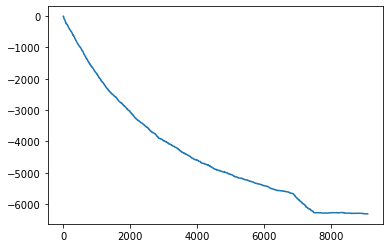

In [81]:
plt.plot(np.r_[:len(a_cov_dp.ML_total_history)], a_cov_dp.ML_total_history)

(-5000.0, -4000.0)

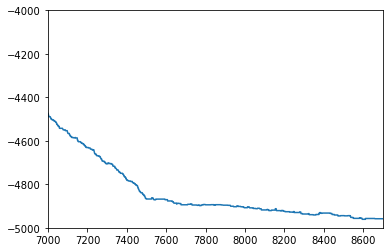

In [72]:
plt.plot(np.r_[:len(a_cov_dp.ML_total_history)], a_cov_dp.ML_total_history)
plt.xlim([7000, 8700])
plt.ylim([-5000, -4000])

In [32]:
ADP_dict = {}
for ADP, group in a_cov_dp.cov_df.loc[a_cov_dp.cov_df.dp_draw == 0].groupby('allelic_cluster'):
    ADP_dict[ADP] = (group['maj_count'].sum(), group['min_count'].sum())

In [33]:
def _scatter_apply(x, minor, major):
    f = np.zeros(len(x))
    f[x.allele == -1] = minor / (minor + major)
    f[x.allele == 1] = major / (minor + major)
    locs = x.start_g.values + (x.end_g.values - x.start_g.values)/2
    return locs, f

In [50]:
import sys

n unassigned: 1547
n unassigned: 1416
n unassigned: 1309
n unassigned: 1213
n unassigned: 1116
n unassigned: 1026
n unassigned: 943
n unassigned: 855
n unassigned: 794
n unassigned: 733
n unassigned: 666
n unassigned: 622
n unassigned: 574
n unassigned: 524
n unassigned: 480
n unassigned: 438
n unassigned: 395
n unassigned: 365
n unassigned: 334
n unassigned: 309
n unassigned: 289
n unassigned: 265
n unassigned: 245
n unassigned: 226
n unassigned: 207
n unassigned: 196
n unassigned: 179
n unassigned: 166
n unassigned: 117
n unassigned: 48
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
burnin
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 1547
n unassigned: 1421
n unassigned: 1304
n unassigned: 1198
n unassigned: 1098
n unassigned: 1010
n unassigned: 917
n unassigned: 849
n unassigned: 777
n unassigned: 712
n unassigned: 665
n unassigned: 611
n unassigned: 563
n unassigned: 517
n unassigned: 477
n unassigned

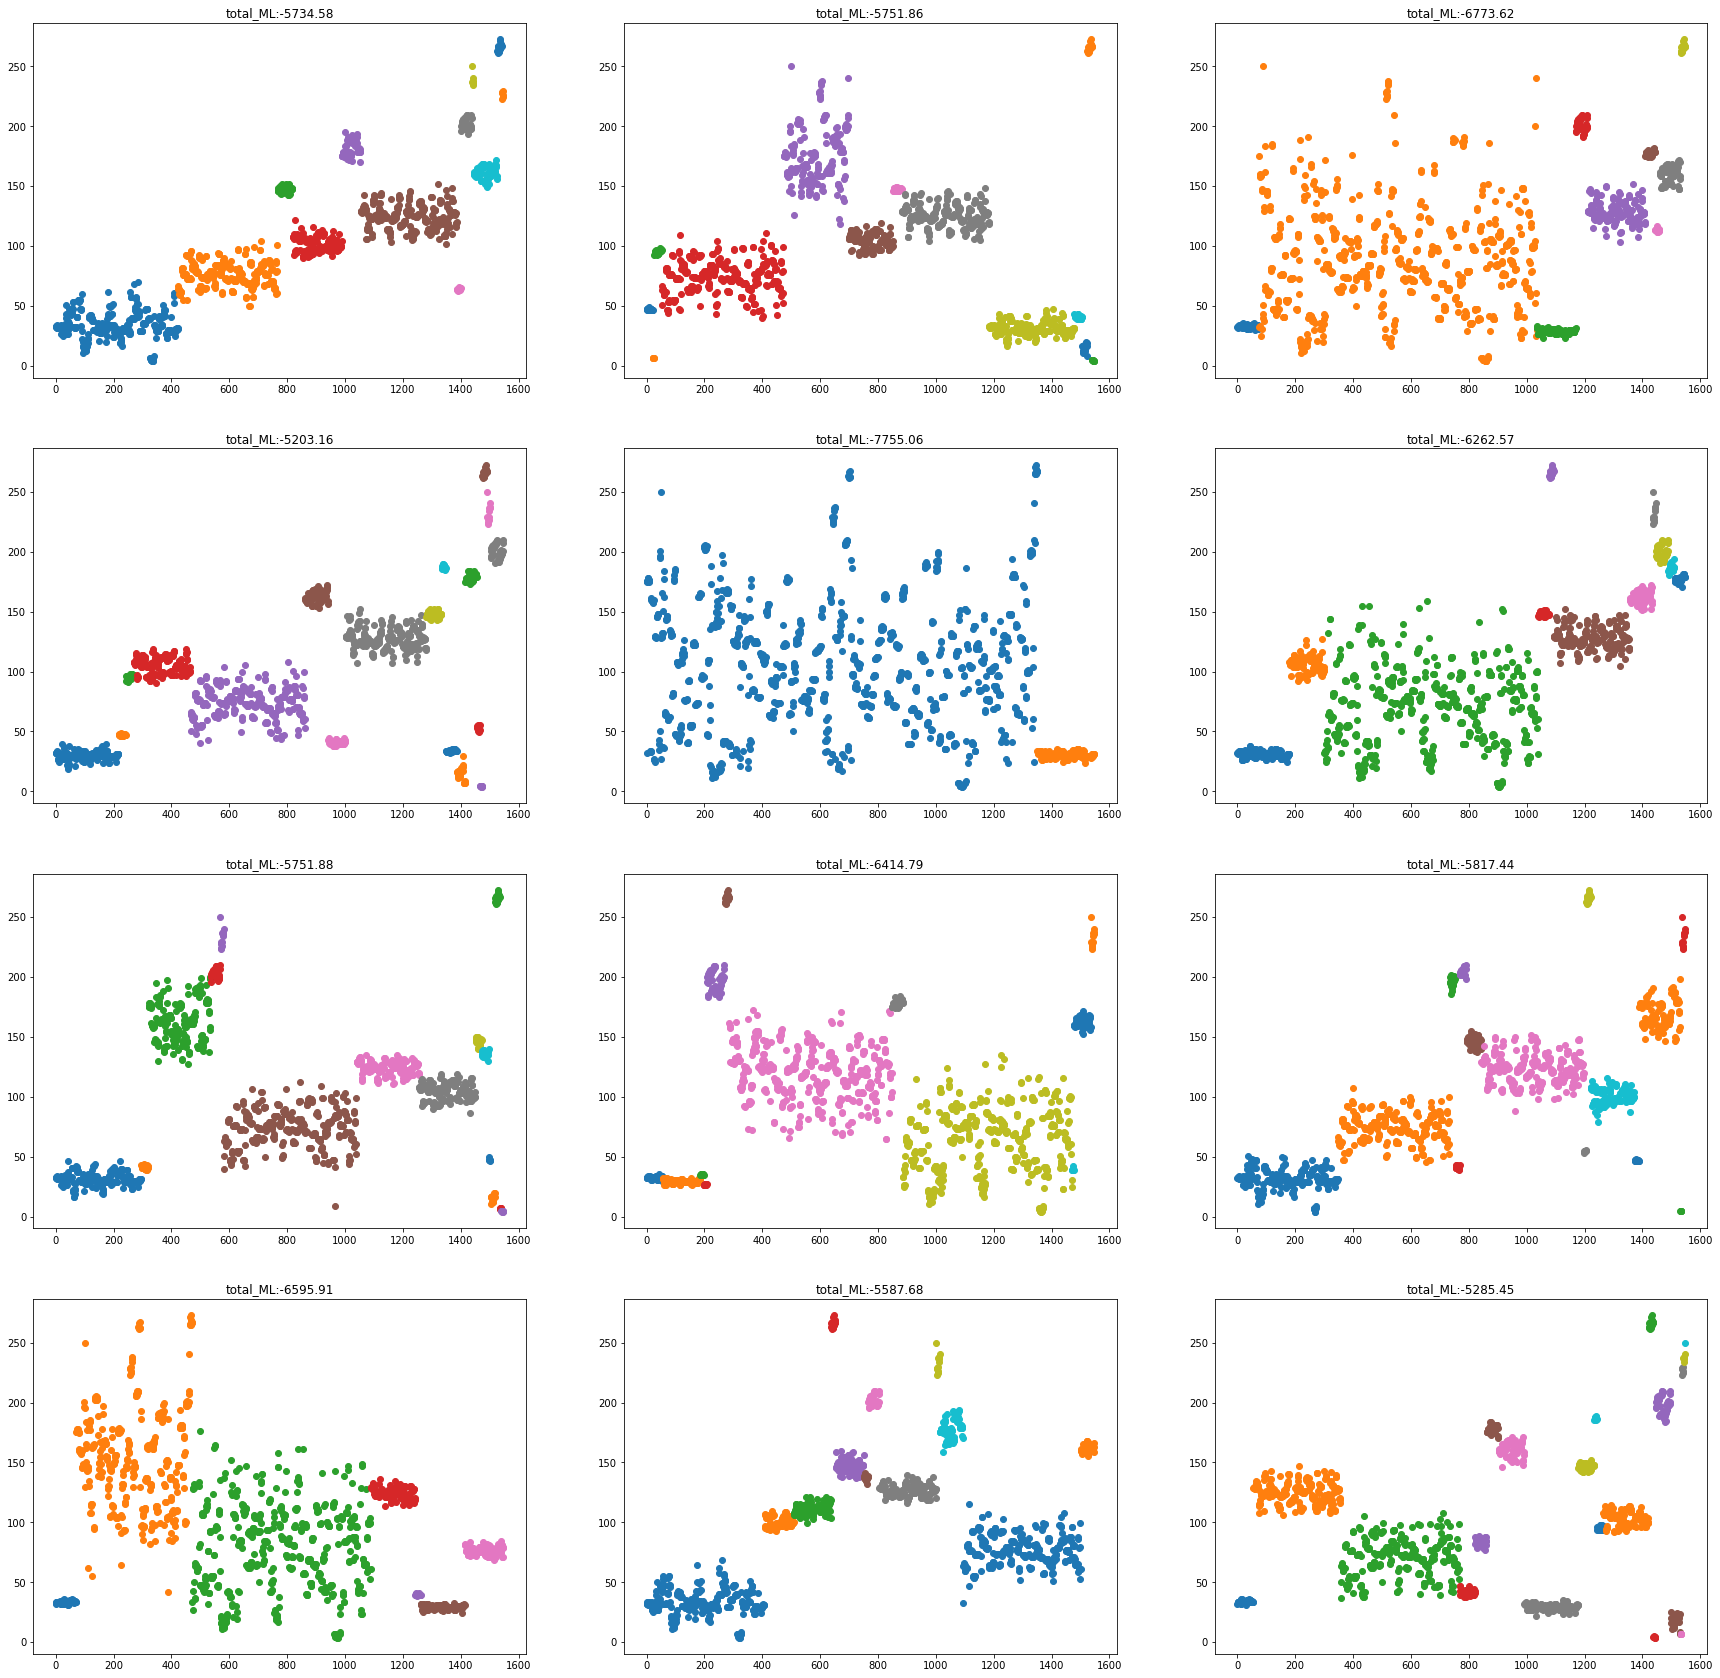

In [88]:
#using coverage prior
f_clust, axs = plt.subplots(4,3, figsize = (30,30))
ax_lst_clust = axs.flatten()
best_a_cov_dp = None
best_ML = -1e30
for run in range(12):
    a_cov_dp = dp_a_cov.Run_Cov_DP(multidraw_df.copy(), dp_pickle.beta, coverage_prior=True)
    a_cov_dp.run(1)
    counter=0
    for c in a_cov_dp.cluster_dict:
        vals = [a_cov_dp.segment_r_list[i] for i in a_cov_dp.cluster_dict[c]]
        ax_lst_clust[run].scatter(np.r_[counter:counter+len(vals)], vals)
        counter+= len(vals)
        ML = a_cov_dp.ML_total_history[-1]
        if ML > best_ML:
            best_ML = ML
            best_a_cov_dp = a_cov_dp
        ax_lst_clust[run].set_title('total_ML:{}'.format(np.around(ML,2)))

In [89]:
a_cov_dp = best_a_cov_dp

In [90]:
best_clust = best_a_cov_dp

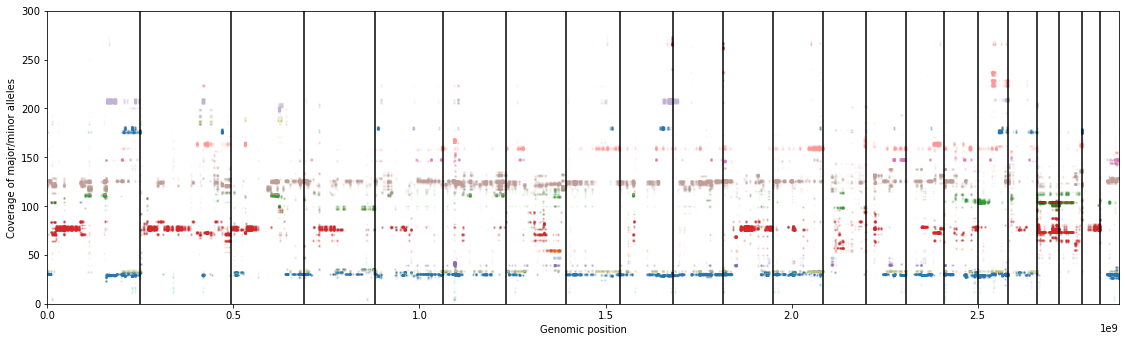

In [91]:
plt.figure(6, figsize = [19.2, 5.39]); plt.clf()
full_df = list(a_cov_dp.cov_df.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']))
for c in a_cov_dp.cluster_dict.keys():
    for s in a_cov_dp.cluster_dict[c]:
        x = full_df[s][1].loc[:,["start_g", "end_g", 'allelic_cluster', 'cov_DP_mu', 'allele', 'maj_count', 'min_count']]
        adp = x['allelic_cluster'].values[0]
        if len(x) > 10:
            major, minor = x['maj_count'].sum(), x['min_count'].sum()
        else:
            major, minor = ADP_dict[adp]
        
        locs, f = _scatter_apply(x, minor,major)
        y = np.exp(x.cov_DP_mu)
        plt.scatter(
            locs,
            f*y,
            color = np.array(colors)[c % len(colors)],
            marker = '.',
            alpha = 0.03,
            s=4
        )

for chrbdy in chr_ends[:-1]:
    plt.axvline(chrbdy, color = 'k')

plt.xlabel("Genomic position")
plt.ylabel("Coverage of major/minor alleles")

plt.xlim((0.0, 2879000000.0));
plt.ylim([0, 300]);

n unassigned: 1547
n unassigned: 1443
n unassigned: 1325
n unassigned: 1227
n unassigned: 1123
n unassigned: 1036
n unassigned: 972
n unassigned: 908
n unassigned: 830
n unassigned: 760
n unassigned: 705
n unassigned: 655
n unassigned: 610
n unassigned: 563
n unassigned: 522
n unassigned: 483
n unassigned: 455
n unassigned: 424
n unassigned: 391
n unassigned: 362
n unassigned: 339
n unassigned: 316
n unassigned: 291
n unassigned: 271
n unassigned: 250
n unassigned: 233
n unassigned: 210
n unassigned: 188
n unassigned: 176
n unassigned: 160
n unassigned: 80
n unassigned: 26
n unassigned: 0
burnin
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 0
n unassigned: 1547
n unassigned: 1425
n unassigned: 1313
n unassigned: 1205
n unassigned: 1121
n unassigned: 1030
n unassigned: 936
n unassigned: 878
n unassigned: 820
n unassigned: 763
n unassigned: 704
n unassigned: 648
n unassigned: 601
n unassigned: 564
n unassigned: 518
n unassigned: 475
n unassigned: 440
n una

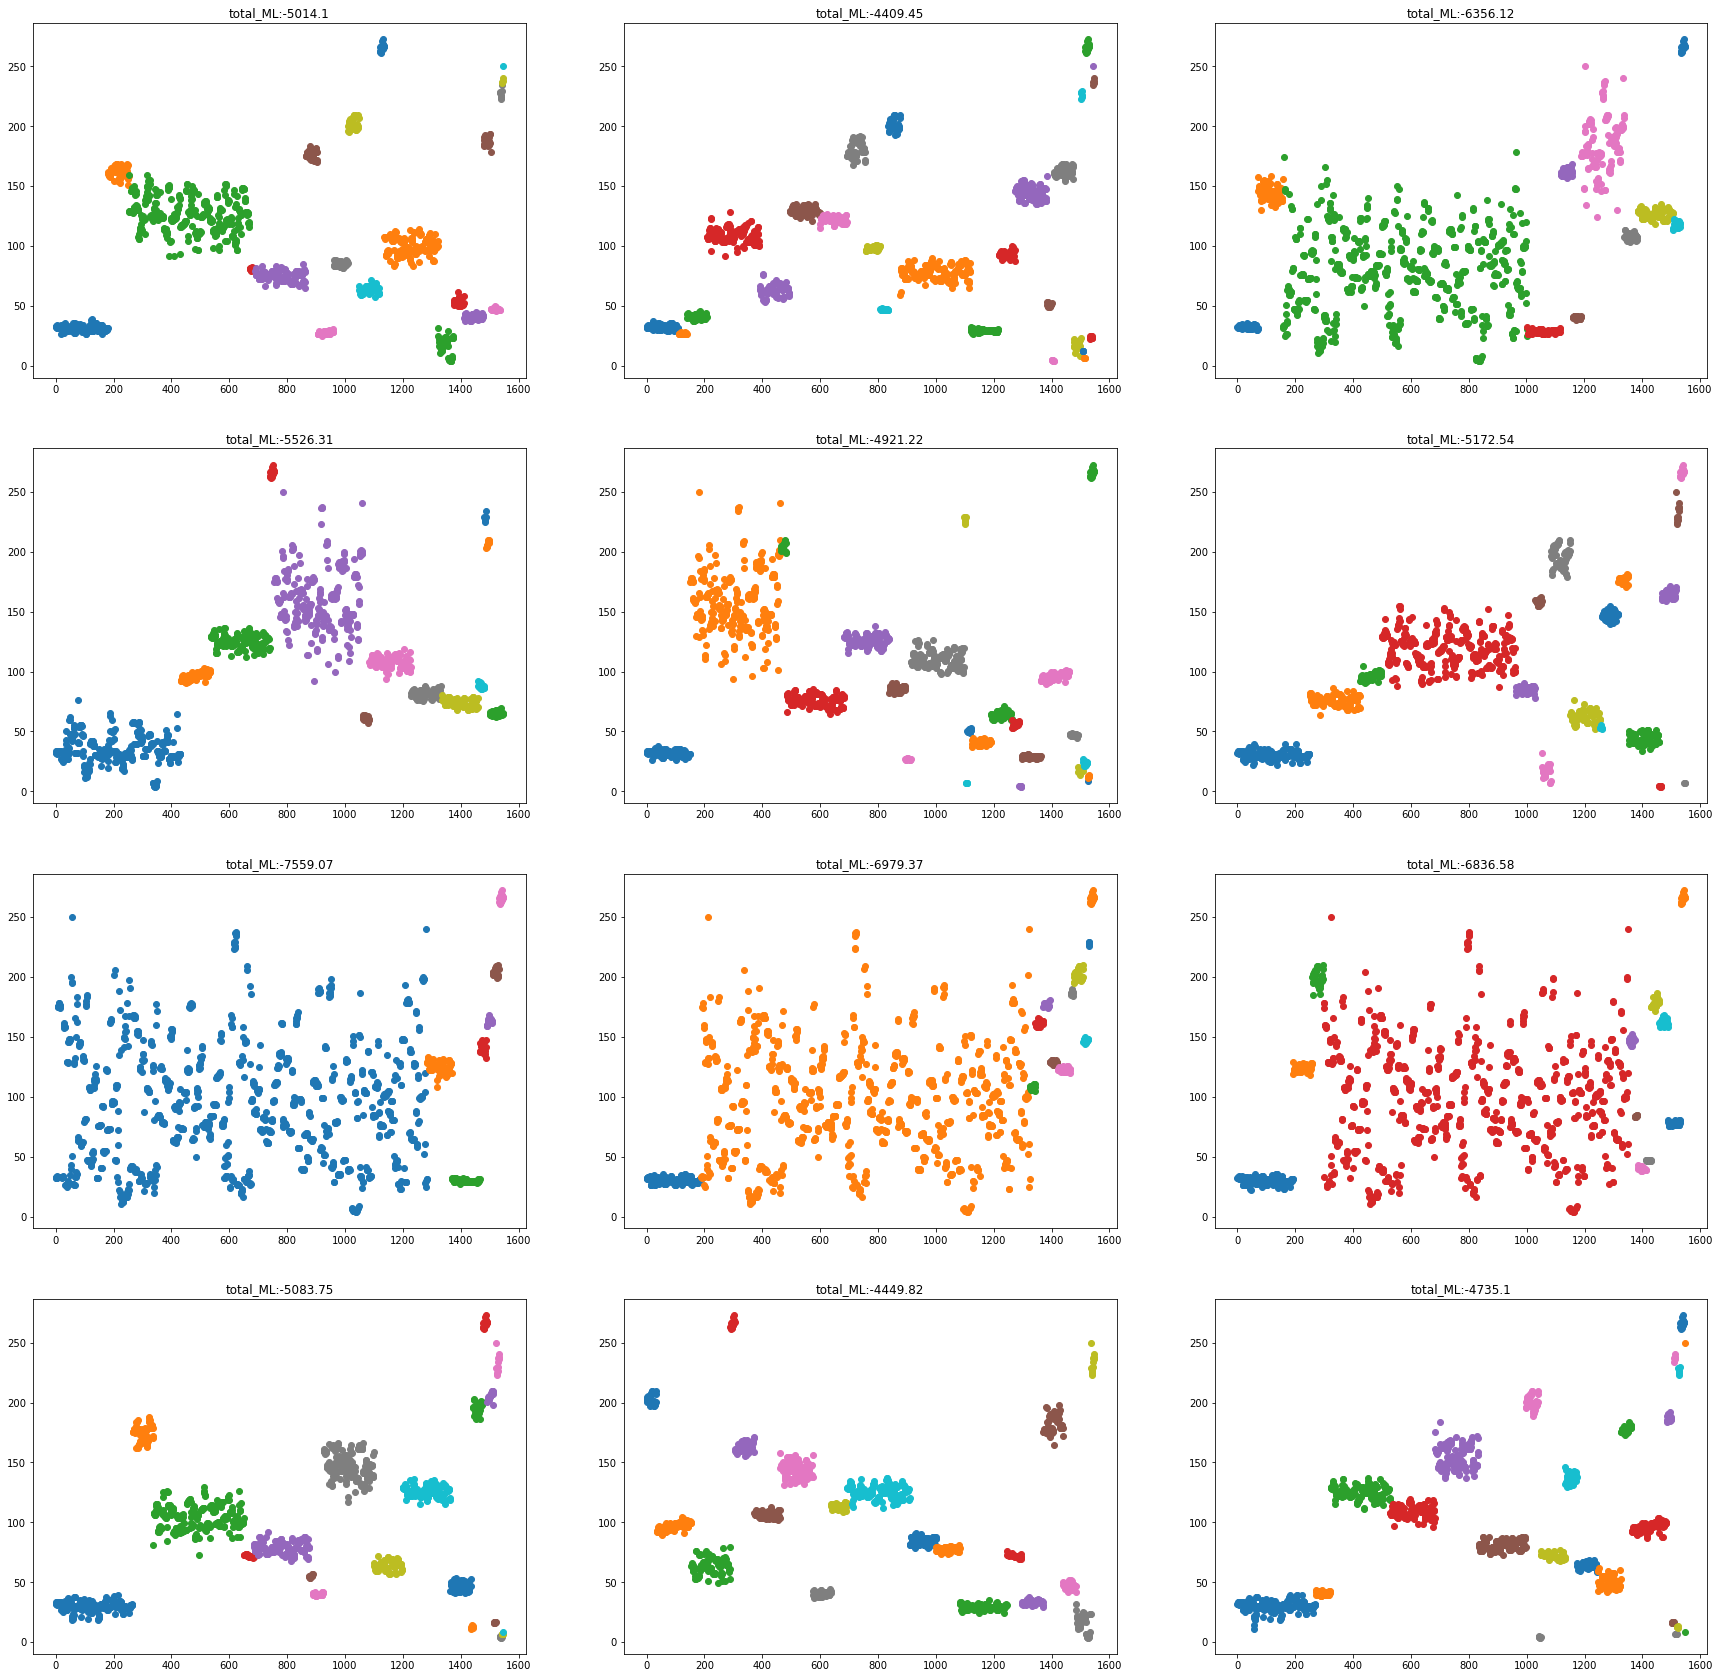

In [83]:
#no coverage prior
f_clust, axs = plt.subplots(4,3, figsize = (30,30))
ax_lst_clust = axs.flatten()
best_a_cov_dp = None
best_ML = -1e30
for run in range(12):
    a_cov_dp = dp_a_cov.Run_Cov_DP(multidraw_df.copy(), dp_pickle.beta, coverage_prior=False)
    a_cov_dp.run(1)
    counter=0
    for c in a_cov_dp.cluster_dict:
        vals = [a_cov_dp.segment_r_list[i] for i in a_cov_dp.cluster_dict[c]]
        ax_lst_clust[run].scatter(np.r_[counter:counter+len(vals)], vals)
        counter+= len(vals)
        ML = a_cov_dp.ML_total_history[-1]
        if ML > best_ML:
            best_ML = ML
            best_a_cov_dp = a_cov_dp
        ax_lst_clust[run].set_title('total_ML:{}'.format(np.around(ML,2)))

In [84]:
a_cov_dp = best_a_cov_dp

In [86]:
best_no_clust = best_a_cov_dp

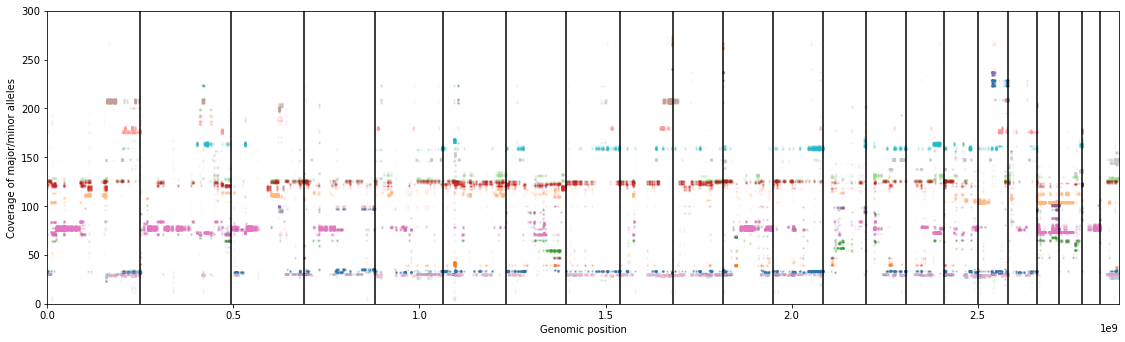

In [85]:
plt.figure(6, figsize = [19.2, 5.39]); plt.clf()
full_df = list(a_cov_dp.cov_df.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']))
for c in a_cov_dp.cluster_dict.keys():
    for s in a_cov_dp.cluster_dict[c]:
        x = full_df[s][1].loc[:,["start_g", "end_g", 'allelic_cluster', 'cov_DP_mu', 'allele', 'maj_count', 'min_count']]
        adp = x['allelic_cluster'].values[0]
        if len(x) > 10:
            major, minor = x['maj_count'].sum(), x['min_count'].sum()
        else:
            major, minor = ADP_dict[adp]
        
        locs, f = _scatter_apply(x, minor,major)
        y = np.exp(x.cov_DP_mu)
        plt.scatter(
            locs,
            f*y,
            color = np.array(colors)[c % len(colors)],
            marker = '.',
            alpha = 0.03,
            s=4
        )

for chrbdy in chr_ends[:-1]:
    plt.axvline(chrbdy, color = 'k')

plt.xlabel("Genomic position")
plt.ylabel("Coverage of major/minor alleles")

plt.xlim((0.0, 2879000000.0));
plt.ylim([0, 300]);

In [98]:
counter=0
for c in best_no_clust.cluster_dict:
    vals = [best_no_clust.segment_r_list[i] for i in best_no_clust.cluster_dict[c]]
    m = np.r_[vals].mean()
    if m < 40:
        print(c, m) 

0 32.85274858121464
1 26.990954602803956
13 29.537459858615367
17 4.445930582193366
19 17.85605906504641
21 12.499066307154688
22 6.876734445175653
24 23.855485057156542


In [99]:
a_cov_dp = best_no_clust

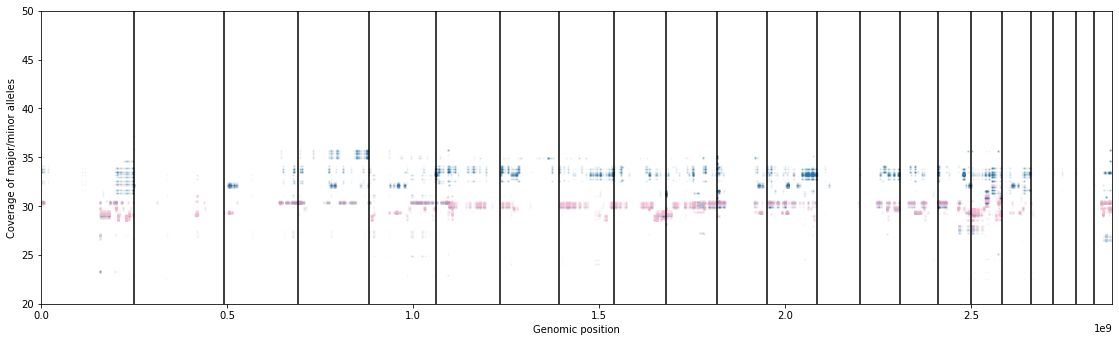

In [102]:
plt.figure(6, figsize = [19.2, 5.39]); plt.clf()
full_df = list(a_cov_dp.cov_df.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']))
for c in [0,1,13,24]:
    for s in a_cov_dp.cluster_dict[c]:
        x = full_df[s][1].loc[:,["start_g", "end_g", 'allelic_cluster', 'cov_DP_mu', 'allele', 'maj_count', 'min_count']]
        adp = x['allelic_cluster'].values[0]
        if len(x) > 10:
            major, minor = x['maj_count'].sum(), x['min_count'].sum()
        else:
            major, minor = ADP_dict[adp]
        
        locs, f = _scatter_apply(x, minor,major)
        y = np.exp(x.cov_DP_mu)
        plt.scatter(
            locs,
            f*y,
            color = np.array(colors)[c % len(colors)],
            marker = '.',
            alpha = 0.03,
            s=4
        )

for chrbdy in chr_ends[:-1]:
    plt.axvline(chrbdy, color = 'k')

plt.xlabel("Genomic position")
plt.ylabel("Coverage of major/minor alleles")

plt.xlim((0.0, 2879000000.0));
plt.ylim([20, 50]);

In [210]:
def _ML_cluster(self, cluster_set):
    r_lst = []
    V_lst = []
    for s in cluster_set:
        r_seg = self.segment_r_list[s]
        r_lst.append(r_seg)
        V_lst.append(self.segment_V_list[s])
    r = np.hstack(r_lst)
    V = np.hstack(V_lst)
    V_sum = ((V - V.mean())**2).sum()
    print(V_sum / len(V))
    print(len(V))
    alpha = 10
    beta = alpha/2 * 100 * V_sum / len(V)
    print(beta)
    return self.ML_normalgamma(r, r.mean(), 0.0000001, alpha, beta)

In [212]:
_ML_cluster(a_cov_dp,a_cov_dp.cluster_dict[0] ) + _ML_cluster(a_cov_dp,a_cov_dp.cluster_dict[13])

0.0040848086651292855
18199
2.042404332564643
0.0033371569965783784
23984
1.6685784982891891


-391.9775668678694

In [213]:
_ML_cluster(a_cov_dp, a_cov_dp.cluster_dict[0].union(a_cov_dp.cluster_dict[13]))

0.003694257292607175
42183
1.8471286463035874


-489.4934402206974

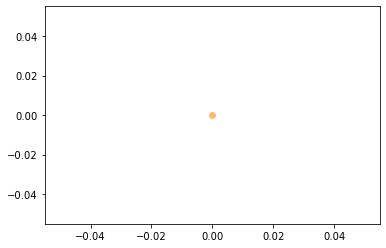

In [109]:
plt.scatter(0,0, color =np.array(colors)[3])

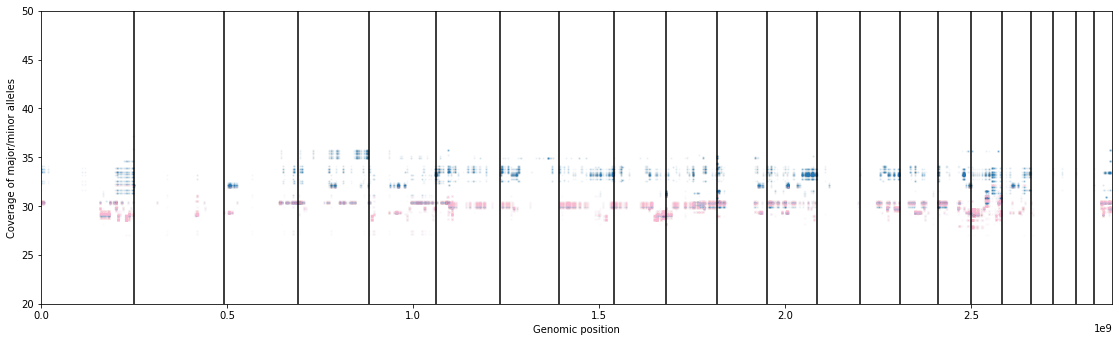

In [197]:
plt.figure(6, figsize = [19.2, 5.39]); plt.clf()
full_df = list(a_cov_dp.cov_df.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']))
for c in [0, 13]:
    for s in a_cov_dp.cluster_dict[c]:
        x = full_df[s][1].loc[:,["start_g", "end_g", 'allelic_cluster', 'cov_DP_mu', 'allele', 'maj_count', 'min_count']]
        adp = x['allelic_cluster'].values[0]
        if len(x) > 10:
            major, minor = x['maj_count'].sum(), x['min_count'].sum()
        else:
            major, minor = ADP_dict[adp]
        
        locs, f = _scatter_apply(x, minor,major)
        y = np.exp(x.cov_DP_mu)
        plt.scatter(
            locs,
            f*y,
            color = np.array(colors)[c % len(colors)],
            marker = '.',
            alpha = 0.03,
            s=4
        )

for chrbdy in chr_ends[:-1]:
    plt.axvline(chrbdy, color = 'k')

plt.xlabel("Genomic position")
plt.ylabel("Coverage of major/minor alleles")

plt.xlim((0.0, 2879000000.0));
plt.ylim([20, 50]);

In [218]:
c0 = pd.DataFrame()
for s in a_cov_dp.cluster_dict[0]:
    c0 = c0.append(full_df[s][1])

In [220]:
c13 = pd.DataFrame()
for s in a_cov_dp.cluster_dict[13]:
    c13 = c13.append(full_df[s][1])

In [248]:
c0.loc[(c0.chr == 22) & (c0.allelic_cluster==0)]

,chr,start,end,covcorr,covraw,start_g,end_g,C_len,C_RT,C_RT_z,C_GC,C_GC_z,allelic_cluster,segment_ID,min_count,maj_count,cov_DP_cluster,cov_DP_mu,cov_DP_sigma,next_g,allele,a_cov_segID,seg_min_count,seg_maj_count,dp_draw
7964,22,23627219,23627388,40726,66804,2853355939,2853356108,170,1.217840,2.792620,0.523529,0.058804,0,5,26.680000,129.412996,7,5.179204,0.000029,2853360423,-1,14967,26.680000,129.412996,5
7980,22,26219471,26219645,40533,64950,2855948191,2855948365,175,0.969796,1.070798,0.577143,0.135097,0,5,34.040000,181.877724,7,5.179204,0.000029,2855968421,-1,14971,148.782958,758.845234,5
7981,22,26239701,26239861,48566,78288,2855968421,2855968581,161,0.969796,1.070798,0.633540,0.208054,0,5,34.040000,173.133603,7,5.179204,0.000029,2855976156,-1,14971,148.782958,758.845234,5
7982,22,26247436,26247546,29652,47585,2855976156,2855976266,111,0.952037,0.931071,0.576577,0.134329,0,5,40.480000,194.993906,7,5.179204,0.000029,2856430664,-1,14971,148.782958,758.845234,5
7983,22,26701944,26702110,39333,59400,2856430664,2856430830,167,0.856236,0.129255,0.562874,0.115508,0,5,40.222958,208.840000,7,5.179204,0.000029,2856558301,-1,14971,148.782958,758.845234,5
7986,22,29445184,29446936,850855,1282684,2859173904,2859175656,1753,0.866276,0.217390,0.678836,0.262092,0,5,70.840000,375.997219,7,5.179204,0.000029,2859432815,-1,14973,70.840000,375.997219,5
8025,22,36122257,36123241,388118,586147,2865850977,2865851961,985,0.908536,0.577487,0.517766,0.050142,0,5,119.794463,644.000000,7,5.179204,0.000029,2866265967,-1,14976,441.081542,2509.150694,5
8026,22,36537247,36538106,304997,463755,2866265967,2866266826,860,0.908624,0.578223,0.524419,0.060132,0,5,108.767080,527.300126,7,5.179204,0.000029,2866315842,-1,14976,441.081542,2509.150694,5
8027,22,36587122,36587958,267720,405152,2866315842,2866316678,837,0.932200,0.771880,0.499403,0.021884,0,5,212.520000,1337.850568,7,5.179204,0.000029,2866320076,-1,14976,441.081542,2509.150694,5
8084,22,43203078,43203169,22509,36699,2872931798,2872931889,92,0.898826,0.496256,0.608696,0.176749,0,5,46.343843,185.840000,7,5.179204,0.000029,2872935538,-1,14986,216.854210,1050.640000,5


In [244]:
c0.loc[c0.chr == 22].head(10).columns

Index(['chr', 'start', 'end', 'covcorr', 'covraw', 'start_g', 'end_g', 'C_len',
       'C_RT', 'C_RT_z', 'C_GC', 'C_GC_z', 'allelic_cluster', 'segment_ID',
       'min_count', 'maj_count', 'cov_DP_cluster', 'cov_DP_mu', 'cov_DP_sigma',
       'next_g', 'allele', 'a_cov_segID', 'seg_min_count', 'seg_maj_count',
       'dp_draw'],
      dtype='object')

In [234]:
c13.loc[c13.chr == 22]

,chr,start,end,covcorr,covraw,start_g,end_g,C_len,C_RT,C_RT_z,...,maj_count,cov_DP_cluster,cov_DP_mu,cov_DP_sigma,next_g,allele,a_cov_segID,seg_min_count,seg_maj_count,dp_draw
7964,22,23627219,23627388,40726,66804,2853355939,2853356108,170,1.217840,2.792620,...,129.412996,7,5.179625,0.000031,2853360423,-1,17688,26.680000,129.412996,6
7980,22,26219471,26219645,40533,64950,2855948191,2855948365,175,0.969796,1.070798,...,181.877724,7,5.179625,0.000031,2855968421,-1,17692,148.782958,758.845234,6
7981,22,26239701,26239861,48566,78288,2855968421,2855968581,161,0.969796,1.070798,...,173.133603,7,5.179625,0.000031,2855976156,-1,17692,148.782958,758.845234,6
7982,22,26247436,26247546,29652,47585,2855976156,2855976266,111,0.952037,0.931071,...,194.993906,7,5.179625,0.000031,2856430664,-1,17692,148.782958,758.845234,6
7983,22,26701944,26702110,39333,59400,2856430664,2856430830,167,0.856236,0.129255,...,208.840000,7,5.179625,0.000031,2856558301,-1,17692,148.782958,758.845234,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8111,22,45255610,45255714,38982,62455,2874984330,2874984434,105,0.916305,0.641864,...,233.680000,7,5.178194,0.000034,2876381177,-1,25900,271.067762,1329.400000,9
8112,22,46652457,46659219,2187793,3300528,2876381177,2876387939,6763,1.025295,1.491523,...,239.200000,7,5.178194,0.000034,2876451052,-1,25900,271.067762,1329.400000,9
8113,22,46722332,46722551,76708,120136,2876451052,2876451271,220,1.104047,2.050996,...,287.960000,7,5.178194,0.000034,2876497499,-1,25900,271.067762,1329.400000,9
8114,22,46768779,46768954,60513,96172,2876497499,2876497674,176,1.113422,2.114923,...,255.760000,7,5.178194,0.000034,2876658243,-1,25900,271.067762,1329.400000,9


In [237]:
full_df = list(a_cov_dp.cov_df.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']))
a_dict = {}
for name, x in full_df:
    maj_count, min_count = x.maj_count.sum(), x.min_count.sum()
    tuple_len = len(x)
    if name[2] == 1:
        f = x.maj_count.sum() / (x.maj_count.sum() + x.min_count.sum())
    else:
        f =x.min_count.sum() / (x.maj_count.sum() + x.min_count.sum())
    a_dict[name] = (maj_count, min_count, f, tuple_len)
    
ADP_dict = {}
for ADP, group in a_cov_dp.cov_df.loc[a_cov_dp.cov_df.dp_draw == 0].groupby('allelic_cluster'):
    ADP_dict[ADP] = (group['maj_count'].sum(), group['min_count'].sum())

def _tst_fun(x):
    name = (x.allelic_cluster.values[0], x.cov_DP_cluster.values[0], x.allele.values[0],x.dp_draw.values[0])

    maj_count, min_count, f, tup_len = a_dict[name]
    if tup_len < 10:
        maj_count, min_count = ADP_dict[name[0]]
        if name[2] == -1:
            f = min_count / (min_count+maj_count)
        else:
            f = maj_count / (min_count+maj_count)
    num_bins = len(x)
    return pd.Series({'DP_mu':np.exp(x.cov_DP_mu.values[0]), 'tup_maj_count':maj_count,  'tup_min_count':min_count, 'tup_len':tup_len, 'num_bins':num_bins, 'f':f,'mu*f':np.exp(x.cov_DP_mu.values[0]) * f})

In [311]:
#blue
c0.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']).apply(_tst_fun)

DP_mu  tup_maj_count  \
allelic_cluster cov_DP_cluster allele dp_draw                              
0               0              -1     0        207.381809   35992.172785   
                                      1        208.963974   75500.935633   
                                      3        210.282830   35112.923483   
                                      4        207.172979   59141.153363   
                                      5        210.604044   60852.006991   
                                      6        210.043967   74156.235102   
                                      7        209.833020   68821.786457   
                                      8        207.362693   67875.371563   
                                      9        207.507090   67198.001097   
                1              -1     0        194.612843  171891.546782   
                                      1        193.111513  131954.528561   
                                      2        192.432542  143908.816572   
                                      3        193.109702  155981.886024   
                                      4        192.265051  145124.097204   
                                      5        193.309934  131954.528561   
                                      6        190.255885  141036.795107   
                                      7        191.331170  146371.243752   
                                      8        192.409375  134130.325527   
                                      9        192.578990  132197.408561   
                7              -1     3        177.501159    9082.266546   
                                      5        177.541459   28836.091975   
                8              -1     3        235.146626   14881.294687   
                22             -1     4        199.064159  465060.978739   
                25             -1     6        180.793701  465060.978739   
                                      7        220.727268  465060.978739   
                                      8        194.963914  465060.978739   
                30             -1     9        213.261623  465060.978739   
1               5              -1     0        108.133068   31166.247452   
                                      1        108.200717   31166.247452   
                                      2        108.298933   29736.577212   
                                      4        108.053408   32481.414784   
                                      5        107.919953   31051.744544   
                                      6        108.570816   32481.414784   
                                      7        108.733006   32481.414784   
                                      8        109.009224   30379.051447   
                                      9        108.314475   30379.051447   
                21             -1     8        121.677752    3572.636712   
3               3              -1     5        154.538088  271507.492011   
                4              -1     3        162.461759   12645.374560   
                                      6        171.818989    9140.794310   
                                      7        181.131511    4819.475423   
                                      8        168.160943    2729.235423   
                7              -1     0        178.256547   10629.506041   
                                      3        177.501159   24528.058349   
                                      4        178.190312   24528.058349   
                                      6        177.616163    6410.386041   
                12             -1     1        154.399035   15313.892840   
                                      3        154.497340   80376.698739   
                                      4        154.710502  117561.681863   
                                      6        157.136069  257281.087232   
                                      9        156.513483  323577.693207   
                25      

In [ ]:
c13.groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']).apply(_tst_fun)

DP_mu  tup_maj_count  \
allelic_cluster cov_DP_cluster allele dp_draw                              
0               0              -1     2        207.715236   62067.287622   
                7              -1     1        176.710529    9082.266546   
                                      6        177.616163   15531.863864   
                                      7        177.888908   15531.863864   
                                      8        177.097501   15531.863864   
                                      9        177.362265   25975.214808   
                12             -1     4        154.710502    9082.266546   
                                      8        156.650645    8839.386546   
1               5              -1     3        107.807318   29380.057111   
                21             -1     9        101.366211    1965.892465   
2               25             -1     8        194.963914    7672.250211   
3               3              -1     0        155.613410  420854.063346   
                                      1        155.654994  405540.170506   
                                      2        156.235852  408757.641125   
                                      3        155.476171  312778.211949   
                                      4        155.259388  289859.992942   
                                      6        153.081978  170397.209234   
                                      7        152.392802  108359.804902   
                                      8        152.841033  108359.804902   
                                      9        153.045735  108359.804902   
                4              -1     0        153.650809    3915.937522   
                                      1        149.680935    3915.937522   
                                      2        158.136370    3915.937522   
                                      4        162.043205    3324.377522   
                                      5        161.823181  946026.383462   
                                      9        160.970150    6354.299190   
                6              -1     0        135.271019   19545.274786   
                                      6        132.231448    8860.673221   
                                      7        132.426066    8860.673221   
                                      8        132.542622   13367.032892   
                                      9        132.592492   13367.032892   
                7              -1     2        177.454330    5732.412489   
                12             -1     2        151.040139   18506.808263   
                                      5        155.886767  157713.005719   
                                      7        157.394995  330082.442081   
                                      8        156.650645  320327.862437   
                22             -1     5        158.931541  946026.383462   
6               1              -1     5        193.309934    8712.631958   
                2              -1     1        258.387494   74143.210218   
                                      2        254.117232   96813.960146   
                                      3        254.927864   96746.394052   
                                      4        256.604296   72319.949712   
                                      5        259.380869   54566.349111   
                                      9        268.695992   54125.709997   
                4              -1     8        168.160943   15228.974255   
                8              -1     0        234.687100  129127.645423   
                                      1        234.415817  129127.645423   
                                      3        235.146626  103310.888139   
                                      4        235.891947  129127.645423   
                                      5        236.898732  147421.912143   
                                      6        238.441417  154685.043646   
                        

In [250]:
c0.loc[c0.chr==22].groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']).apply(_tst_fun)

DP_mu  tup_maj_count  \
allelic_cluster cov_DP_cluster allele dp_draw                              
0               7              -1     5        177.541459   28836.091975   
1               5              -1     0        108.133068   31166.247452   
                                      1        108.200717   31166.247452   
                                      2        108.298933   29736.577212   
3               7              -1     0        178.256547   10629.506041   
                                      3        177.501159   24528.058349   
                                      4        178.190312   24528.058349   
                                      6        177.616163    6410.386041   
                12             -1     9        156.513483  323577.693207   
6               7              -1     0        178.256547    5714.221086   
11              6              -1     9        132.592492   30191.873897   
15              7              -1     3        177.501159   74565.755980   

                                               tup_min_count  tup_len  \
allelic_cluster cov_DP_cluster allele dp_draw                           
0               7              -1     5          6249.975827     75.0   
1               5              -1     0         13187.640451    215.0   
                                      1         13187.640451    215.0   
                                      2         12587.772360    207.0   
3               7              -1     0          2662.085511     35.0   
                                      3          5683.227230     82.0   
                                      4          5683.227230     82.0   
                                      6          1552.456510     21.0   
                12             -1     9         77651.219018   1178.0   
6               7              -1     0          1198.915600     20.0   
11              6              -1     9          8492.447811    143.0   
15              7              -1     3         15016.688442    194.0   

                                               num_bins         f       mu*f  
allelic_cluster cov_DP_cluster allele dp_draw                                 
0               7              -1     5            48.0  0.178133  31.625939  
1               5              -1     0             1.0  0.297328  32.150959  
                                      1             1.0  0.297328  32.171073  
                                      2             1.0  0.297412  32.209410  
3               7              -1     0            21.0  0.200283  35.701832  
                                      3            82.0  0.188116  33.390814  
                                      4            82.0  0.188116  33.520455  
                                      6            21.0  0.194963  34.628509  
                12             -1     9           103.0  0.193533  30.290596  
6               7              -1     0            20.0  0.173426  30.914267  
11              6              -1     9            14.0  0.219532  29.108299  
15              7              -1     3            23.0  0.167630  29.754486

In [ ]:
c13[c13.chr==22].groupby(['allelic_cluster', 'cov_DP_cluster', 'allele', 'dp_draw']).apply(_tst_fun)

DP_mu  tup_maj_count  \
allelic_cluster cov_DP_cluster allele dp_draw                              
0               7              -1     6        177.616163   15531.863864   
                                      7        177.888908   15531.863864   
                                      8        177.097501   15531.863864   
                                      9        177.362265   25975.214808   
3               3              -1     0        155.613410  420854.063346   
                                      1        155.654994  405540.170506   
                                      2        156.235852  408757.641125   
                                      3        155.476171  312778.211949   
                                      4        155.259388  289859.992942   
                                      6        153.081978  170397.209234   
                12             -1     5        155.886767  157713.005719   
                                      7        157.394995  330082.442081   
                                      8        156.650645  320327.862437   
11              6              -1     0        135.271019   32437.499181   
                                      1        135.227091   32437.499181   
                                      2        133.085902   32437.499181   
                                      3        133.623123   29227.881786   
                                      4        133.709244   29227.881786   
                                      5        133.189922   32523.755616   
                                      6        132.231448   30429.428360   
                                      7        132.426066   28848.841786   
                                      8        132.542622   30191.873897   
15              7              -1     0        178.256547   75558.675019   
                                      1        176.710529   70614.788826   
                                      2        177.454330   78462.992540   
                                      4        178.190312   74922.715980   
                                      5        177.541459   74922.715980   
                                      6        177.616163   66034.672721   
                                      7        177.888908   75236.016941   
                                      8        177.097501   78462.992540   
                                      9        177.362265   78462.992540   

                                               tup_min_count  tup_len  \
allelic_cluster cov_DP_cluster allele dp_draw                           
0               7              -1     6          3086.115853     48.0   
                                      7          3086.115853     48.0   
                                      8          3086.115853     48.0   
                                      9          5263.695625     84.0   
3               3              -1     0        101721.775117   1594.0   
                                      1         98011.577293   1530.0   
                                      2         98797.364448   1538.0   
                                      3         75435.635453   1181.0   
                                      4         69762.947262   1094.0   
                                      6         41276.181733    691.0   
                12             -1     5         38309.687423    583.0   
                                      7         79314.750598   1200.0   
                                      8         76867.040561   1167.0   
11              6              -1     0          9113.107330    154.0   
                                      1          9113.107330    154.0   
                                      2          9113.107330    154.0   
                                      3          8260.172792    139.0   
                                      4          8260.172792    139.0   
                                      5          9140.139416    156.0   
          

In [309]:
a_cov_dp.cov_df.allelic_cluster.value_counts()

3     35660
5     24420
4     17260
0     14620
1     11700
8     11000
6     10740
9      9280
11     9040
7      6860
15     4240
16     2580
12     2520
17     1440
18      820
2       540
10      140
13       80
14       60
Name: allelic_cluster, dtype: int64

In [310]:
a_cov_dp.cov_df.loc[a_cov_dp.cov_df.allelic_cluster==3].cov_DP_cluster.value_counts()

3     20058
12    11908
6      1588
0       868
7       474
4       384
1       268
21       40
22       24
25       20
5        20
30        8
Name: cov_DP_cluster, dtype: int64

In [308]:
a_cov_dp.cov_df.loc[a_cov_dp.cov_df.cov_DP_cluster==0].allelic_cluster.value_counts()

0     3048
4     2818
16    2580
8     2518
3      868
1       90
7       70
17      58
12      34
5       28
2        6
11       4
Name: allelic_cluster, dtype: int64

In [265]:
tst = np.load('/home/opriebe/dev/HapASeg/exome_results/coverage_mcmc_clusters/cov_mcmc_data_cluster_0.npz')

In [269]:
np.max(tst['seg_samples'], axis=0)

array([ 4.,  5.,  7.,  8.,  7.,  5.,  5.,  5.,  8., 10.])

<img src='exome_results/coverage_mcmc_clusters/figures/cov_mcmc_cluster_11_visual.png' />

<img src='exome_results/coverage_figures/coverage_draw_9.png' />

In [295]:
c0.loc[(c0.allelic_cluster==9) & (c0.dp_draw==6)].segment_ID.unique()

array([116])

In [296]:
c13.loc[(c13.allelic_cluster==9) & (c13.dp_draw==6)].segment_ID.unique()

array([114, 117, 118, 119, 121, 123])

In [299]:
c0.loc[c0.allelic_cluster==9].cov_DP_cluster.unique()

array([5, 6])

In [300]:
c13.loc[c13.allelic_cluster==9].cov_DP_cluster.unique()

array([5])